# Lightning

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchmetrics import MeanAbsoluteError, MinMetric, MeanMetric
from PIL import Image
from xml.etree import ElementTree as ET
from typing import Any, Tuple
from lightning import LightningDataModule, LightningModule, Trainer
import torch
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
import numpy as np

class FaceDataset(Dataset):
    class RawRecord:
        image: Image
        width: int
        height: int
        box_top: int
        box_left: int
        box_width: int
        box_height: int
        landmarks: list[int]

    def __init__(self, path, data_dir: str) -> None:
        super().__init__()
        self.images = ET.parse(path).getroot()[2]
        self.data_dir = data_dir

        self.transforms = A.Compose([
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy'))
        
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Any:
        data = self.images[index]
        landmarks = []
        for landmark in data[0]:
            landmarks.append((float(landmark.attrib['x']), float(landmark.attrib['y'])))
        transformed = self.transforms(
            image=np.array(Image.open(self.data_dir + data.attrib['file']).convert('RGB')), 
            keypoints=landmarks)
        image = transformed['image']
        landmarks = torch.tensor(transformed['keypoints']).flatten() / 244
        return image, landmarks
    
class FaceDataModule(LightningDataModule):
    def __init__(
        self,
        train_val_split: Tuple[int, int] = (0.8, 0.2),
        data_dir: str = "./data/",
        batch_size: int = 64,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.num_workers = num_workers
        self.train_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'
        self.test_path = data_dir + 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml'
        train_dataset = FaceDataset(self.train_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')
        (self.data_train, self.data_val) = random_split(
            dataset=train_dataset,
            lengths=train_val_split,
            generator=torch.Generator().manual_seed(42),
        )
        self.data_test: Dataset = FaceDataset(self.test_path, data_dir=data_dir + 'ibug_300W_large_face_landmark_dataset/')

        self.batch_size_per_device = batch_size

    @property
    def num_classes(self) -> int:
        return 136

    def train_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.num_workers,
            shuffle=False,
        )

class FaceModule(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
        self.net.classifier = torch.nn.Linear(1280, 136)
        self.criterion = torch.nn.MSELoss()
        self.metric = MeanAbsoluteError()

         # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_loss_best = MinMetric()

    def on_train_start(self) -> None:
        self.train_loss.reset()
        self.val_loss.reset()
        self.val_loss_best.reset()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
    def configure_optimizers(self) -> Any:
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # self.train_losses.append(loss.item())
        self.train_loss(loss)
        self.log("train/loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # self.val_losses.append(loss.item())
        self.val_loss(loss)
        self.log("val/loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # self.test_losses.append(loss.item())
        self.test_loss(loss)
        self.log("test/loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss
    
    def predict_step(self, img: Image) -> Any:
        t = A.Compose([
            A.Resize(244, 244),
            A.Normalize(),
            ToTensorV2(),
        ])
        transformed = t(image=np.array(img))
        image = transformed['image']
        logits = self.forward(image.unsqueeze(0))
        return logits.squeeze(0)

    def save_to_state_dict(self, path: str):
        torch.save(self.state_dict(), path)

    def load_from_state_dict(self, path: str):
        self.load_state_dict(torch.load(path))
    

In [6]:
model = FaceModule()
datamodule = FaceDataModule(data_dir='../data/', batch_size=16, num_workers=0, train_val_split=(0.8, 0.2))
model = FaceModule()
trainer = Trainer(
    max_epochs=2,
    accelerator="gpu",
    devices=1,
)

Using cache found in C:\Users\mrAvo/.cache\torch\hub\pytorch_vision_v0.9.0
c:\Users\mrAvo\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mrAvo\miniconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\mrAvo/.cache\torch\hub\pytorch_vision_v0.9.0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\mrAvo\miniconda3\envs\ml\Lib\site-

In [7]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | MobileNetV2       | 2.4 M 
1 | criterion     | MSELoss           | 0     
2 | metric        | MeanAbsoluteError | 0     
3 | train_loss    | MeanMetric        | 0     
4 | val_loss      | MeanMetric        | 0     
5 | test_loss     | MeanMetric        | 0     
6 | val_loss_best | MinMetric         | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.592     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\mrAvo\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\mrAvo\miniconda3\envs\ml\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 334/334 [05:45<00:00,  0.97it/s, v_num=1, train/loss=0.00676, val/loss=0.00393]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 334/334 [05:45<00:00,  0.97it/s, v_num=1, train/loss=0.00676, val/loss=0.00393]


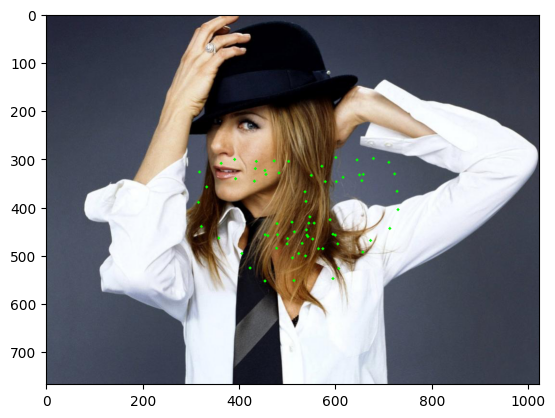

In [21]:
# Predict
from PIL import Image
import cv2
from matplotlib import pyplot as plt


def draw(image, landmarks):
    # draw image and point landmarks
    image = image.copy()
    for landmark in landmarks:
        cv2.circle(image, (landmark[0], landmark[1]), 1, (0, 255, 0), 3)
    plt.imshow(image)
    

img = Image.open('../data/ibug_300W_large_face_landmark_dataset/ibug/image_003_1.jpg')

landmarks = model.predict_step(img=img)
landmarks = landmarks.detach().numpy().reshape((68, 2)) * np.array([img.width, img.height])
landmarks = landmarks.astype(int)

draw(np.array(img), landmarks)